In [1]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

class CustomScaler(BaseEstimator):
    def __init__(self, columns ):
        self.scaler = StandardScaler()
        self.columns = columns
        self.mean_ = None
        self.std_ = None
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns], y)
        self.mean_ = np.mean(X[self.columns])
        self.std_ = np.std(X[self.columns])
        return self
    
    def transform(self, X, y=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.columns]), columns=self.columns,index=X.index)
        X_not_scaled = X.loc[:, ~X.columns.isin(self.columns)]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

In [3]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [4]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
#     if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
#         columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


<img src="https://i.imgur.com/J4QlqZu.jpg"/>


## Introduction
Greetings starter code demonstrating how to read in the data and begin exploring. Click the blue "Edit Notebook" or "Fork Notebook" button at the top of this kernel to begin editing.



## Exploratory Analysis

In [5]:
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics

There is 1 csv file in the current version of the dataset:


In [6]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/Boston-house-price-data.csv


In [7]:
df = pd.read_csv('/kaggle/input/Boston-house-price-data.csv', delimiter=',')
df.sample(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
36,0.09744,0.0,5.96,0,0.499,5.841,61.4,3.3779,5,279.0,19.2,377.56,11.41,20.0
183,0.10008,0.0,2.46,0,0.488,6.563,95.6,2.8470,3,193.0,17.8,396.90,5.68,32.5
374,18.49820,0.0,18.10,0,0.668,4.138,100.0,1.1370,24,666.0,20.2,396.90,37.97,13.8
63,0.12650,25.0,5.13,0,0.453,6.762,43.4,7.9809,8,284.0,19.7,395.58,9.50,25.0
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


**Analysis:**
* here we observe that all columns are of numeric datatype
* we can also observe that all of non-null column values have 506, which is fortunately equals to total rows in dataframe
* i.e., we dont have any null values in this dataframe

In [9]:
print('total number of null values : {0}'.format(df.isna().sum().sum()))

total number of null values : 0


In [10]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


**Analysis**
* here if we observe standard-deviation is much larger than mean for few of the columns which we need to normalize
* we need to check the distribution by ploting the data, and do the required normalizations

# Multivariate Analysis

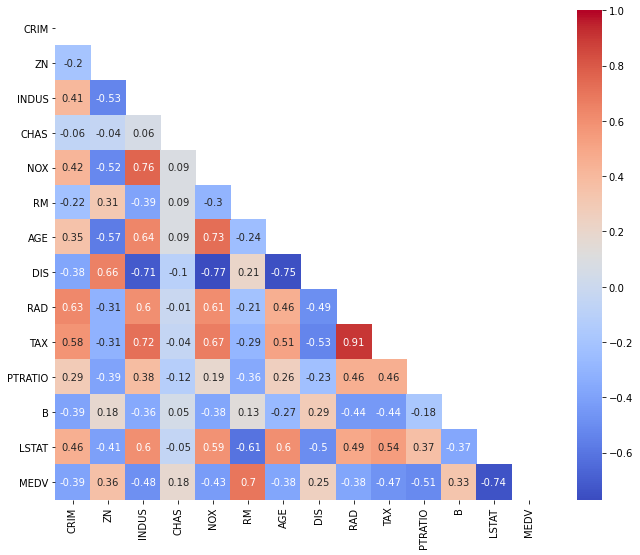

In [11]:
plt.figure(figsize=(11,9))
corr = df.corr().round(2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# # Want diagonal elements as well
# mask[np.diag_indices_from(mask)] = False

sns.heatmap(data=corr, annot=True,cmap='coolwarm',mask=mask)
plt.xticks(rotation=90)
plt.show()

**Analysis**
* columns RAD & TAX are highly positively correlated 
    * **inference**: as the accessibility to radial highways increases so does the porperty TAX
* columns DIS is highly negatively correlated with INDUS, NOX, AGE
    * **inference**: as the distances to five boston employment centres increases
    * proportion of non-retail business acres per town decreases
    * nitric oxides concentration (parts per 10 million) decreases
    * proportion of owner-occupied units built prior to 1940 decreases
* column LSTAT & MEDV are highly negatively correlated
    * **inference**: as the % lower status of the population increases 
    * Median value of owner-occupied homes decreases

# Univariate Analysis

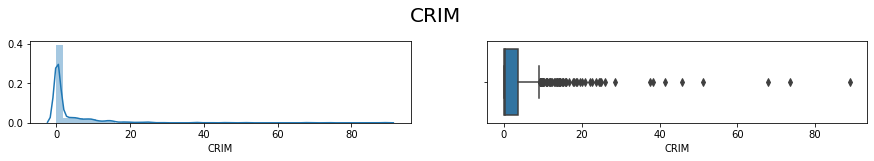

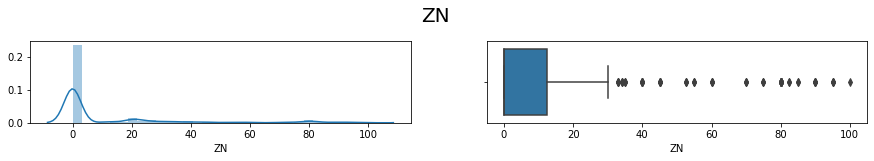

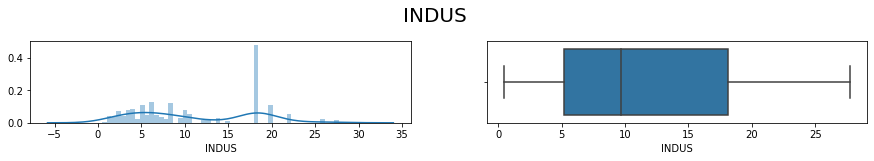

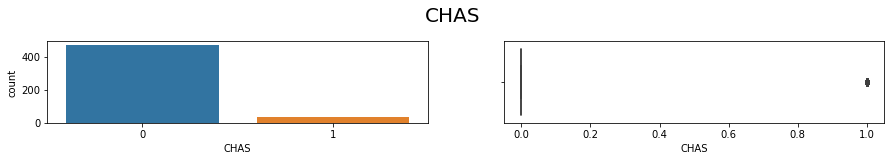

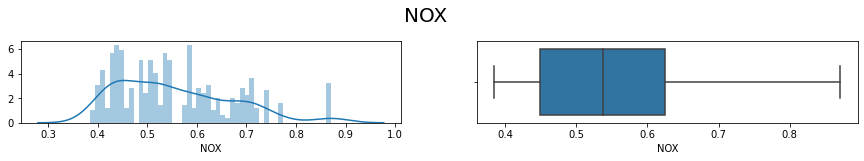

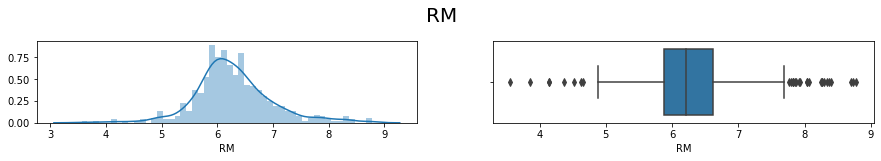

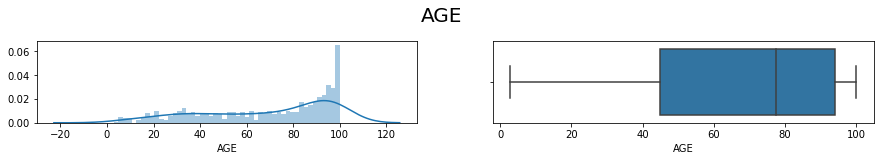

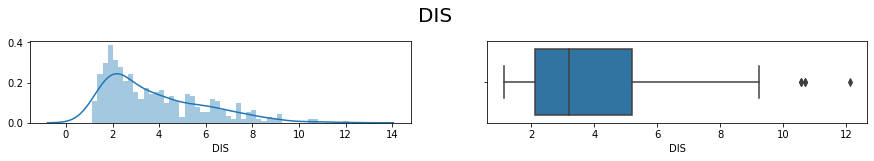

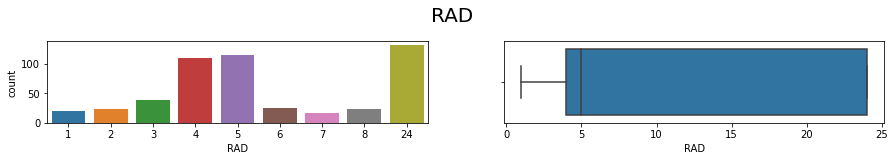

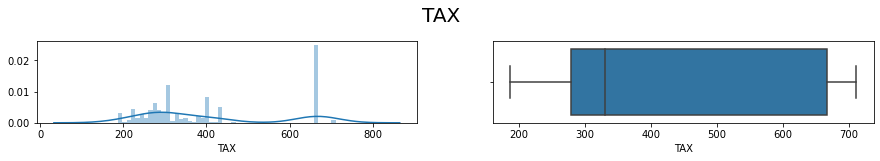

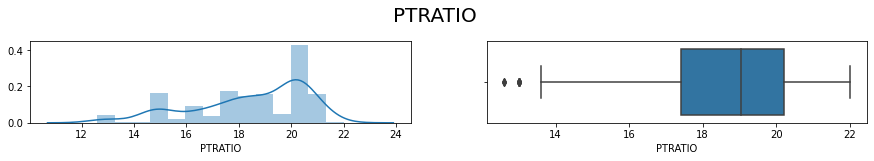

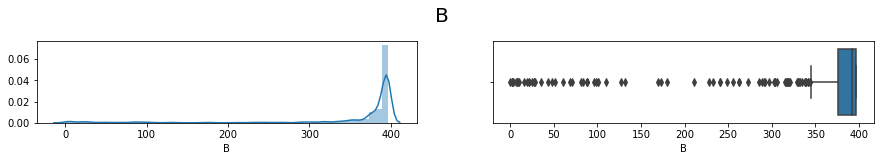

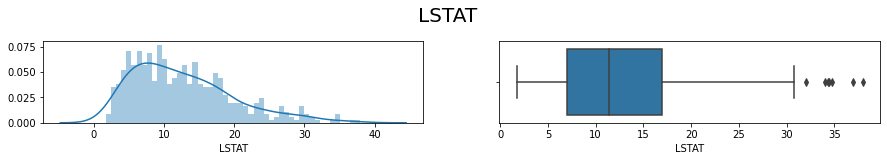

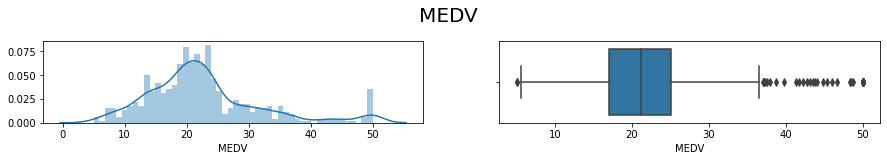

In [12]:
for col in df.columns:
    fig,ax = plt.subplots(1,2,figsize=(15,1.5))
    if len(np.unique(df[col]))<10:
        sns.countplot(df[col],ax=ax[0])
    else:
        sns.distplot(df[col],bins=50 if len(np.unique(df[col]))>50 else None,ax=ax[0])
        
    sns.boxplot(df[col],ax=ax[1])
    plt.suptitle(col,fontsize=20,y=1.2)
    plt.show()

# Normalization

### Now lets select few columns from do some normalization techniques

In [13]:
columns = [col for col in df.columns if len(np.unique(df[col]))>50]
columns.remove('MEDV')
columns

['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'B', 'LSTAT']

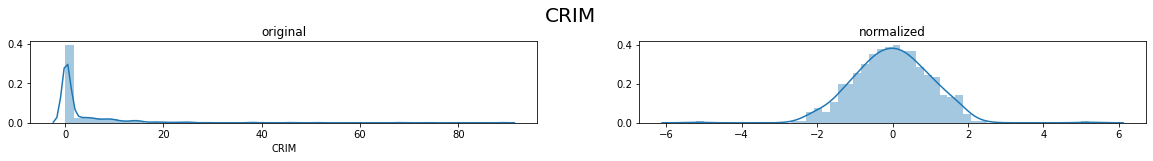

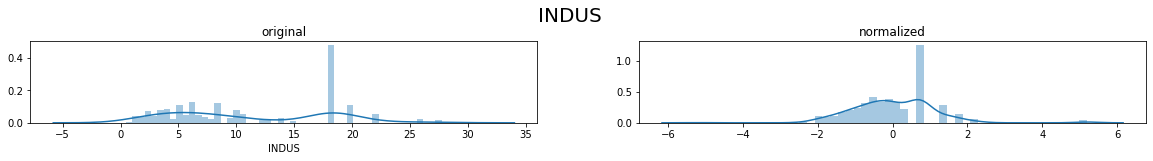

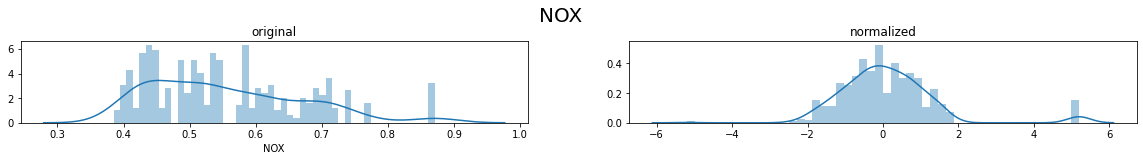

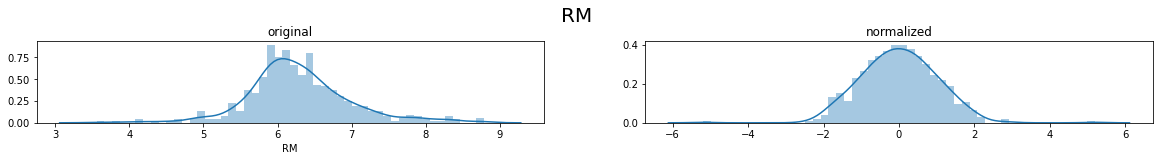

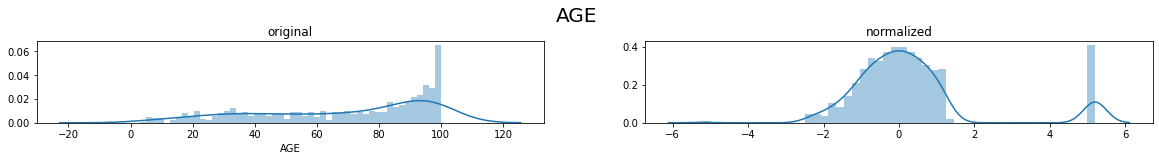

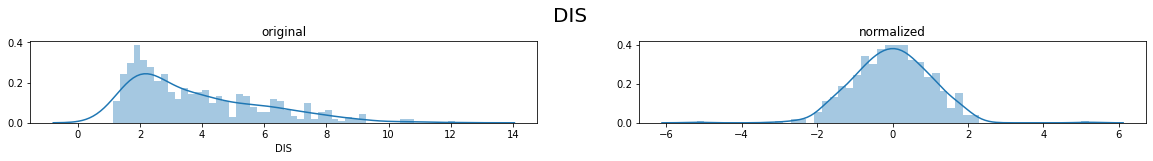

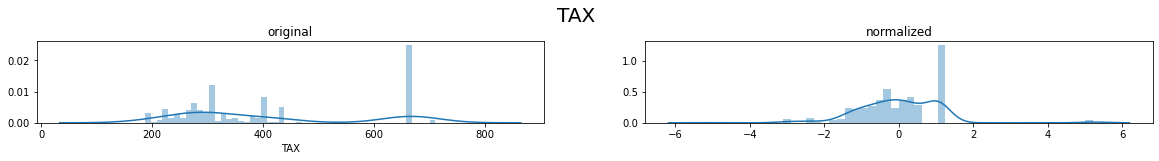

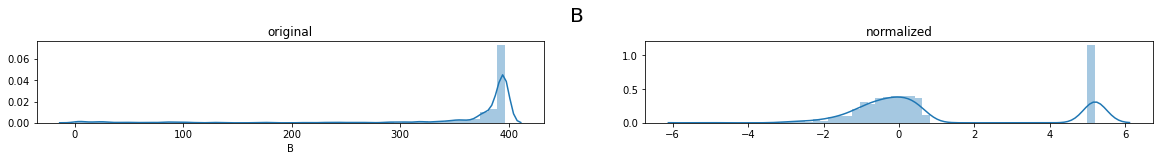

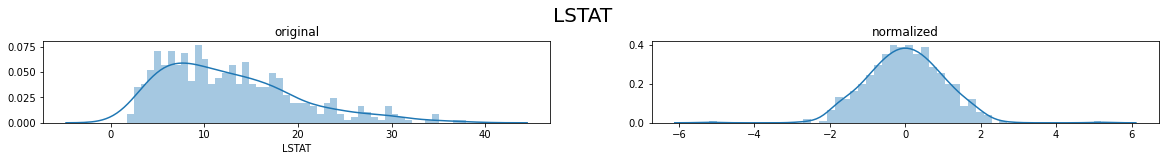

In [14]:
for col in columns:
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,1.5))
    
    sns.distplot(df[col],bins=50,ax=ax[0])
    ax[0].set_title('original')
    
    quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal',n_quantiles=int(len(df)/20), random_state=0)
    X_trans = quantile_transformer.fit_transform(df[col].values.reshape((len(df),1)))
    sns.distplot(X_trans,bins=50,ax=ax[1])
    ax[1].set_title('normalized')
    
    plt.suptitle(col,fontsize=20,y=1.2)
    plt.show()

# Operations on dataset

In [15]:
columns

['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'B', 'LSTAT']

In [16]:
c = columns.copy()
c.append('MEDV')
X = df[c]
X_train = X.copy()

### Clipping outliers from train data

In [17]:
for k, v in X_train.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(X_train)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.04%
Column INDUS outliers = 0.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column TAX outliers = 0.00%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


In [18]:
len(X_train)

506

In [19]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

X_train = X_train[~((X_train < (Q1 - 1.5 * IQR)) |(X_train > (Q3 + 1.5 * IQR))).any(axis=1)]

In [20]:
len(X_train)

349

### Target Variable MEDV

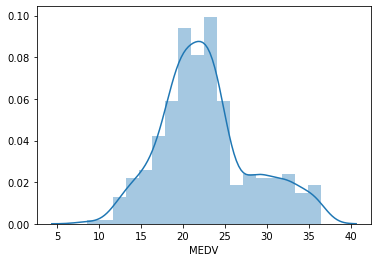

In [21]:
sns.distplot(X_train['MEDV']);plt.show()

### Independent variables (INPUTS)

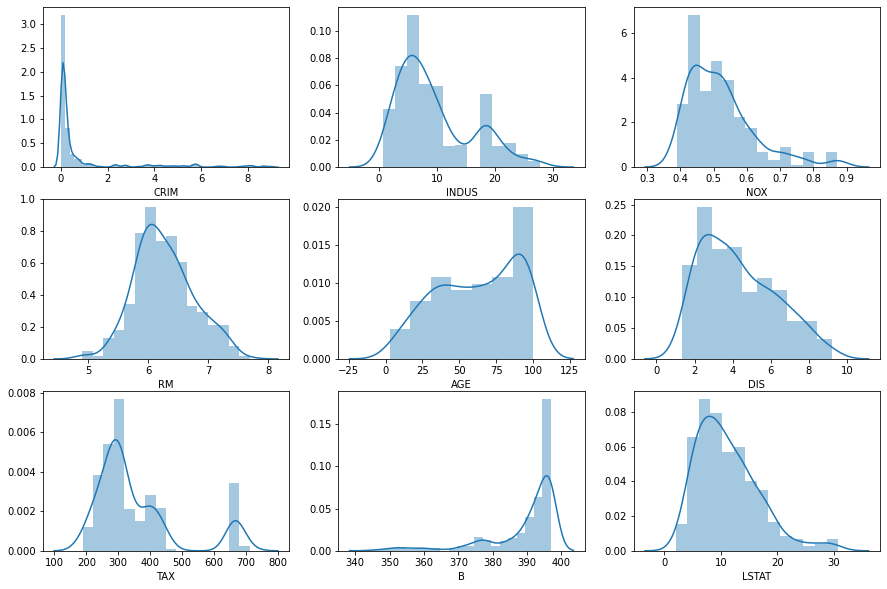

In [22]:
cols = 3
rows = int(len(X_train.drop('MEDV',axis=1).columns)/cols)

plt.figure(figsize=(15,10))
for i,col in enumerate(X_train.drop('MEDV',axis=1).columns):
    ax = plt.subplot(rows, cols, i+1)
    sns.distplot(X_train[col],ax=ax)

In [23]:
X.columns

Index(['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'B', 'LSTAT',
       'MEDV'],
      dtype='object')

In [24]:
X_train, y_train = X_train.drop('MEDV',axis=1), X_train['MEDV']

### LOG Transform target variable for better results

In [25]:
y_train = np.log(y_train)

as the data is small lets not split for the validation data instead go for cross validation

lets do normalization on the train and transform test data with it

# Normalization

In [26]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal',n_quantiles=int(len(X_trans)/20), random_state=0)
X_train.loc[:,columns] = quantile_transformer.fit_transform(X_train[columns].values.reshape((len(X_train),len(columns))))

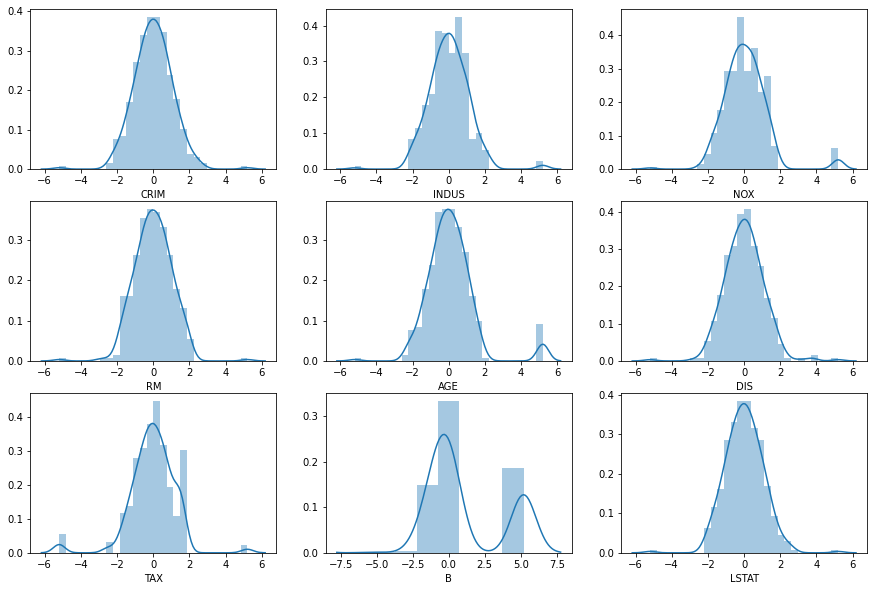

In [27]:
cols = 3
rows = int(len(X_train.columns)/cols)

plt.figure(figsize=(15,10))
for i,col in enumerate(X_train.columns):
    ax = plt.subplot(rows, cols, i+1)
    sns.distplot(X_train[col],ax=ax)

# Standardization

In [28]:
scaler = CustomScaler(columns)#check at the start of the book to find the CustomScaler
scaler.fit(X_train)
X_train = scaler.transform(X_train)

now the data has been scaled

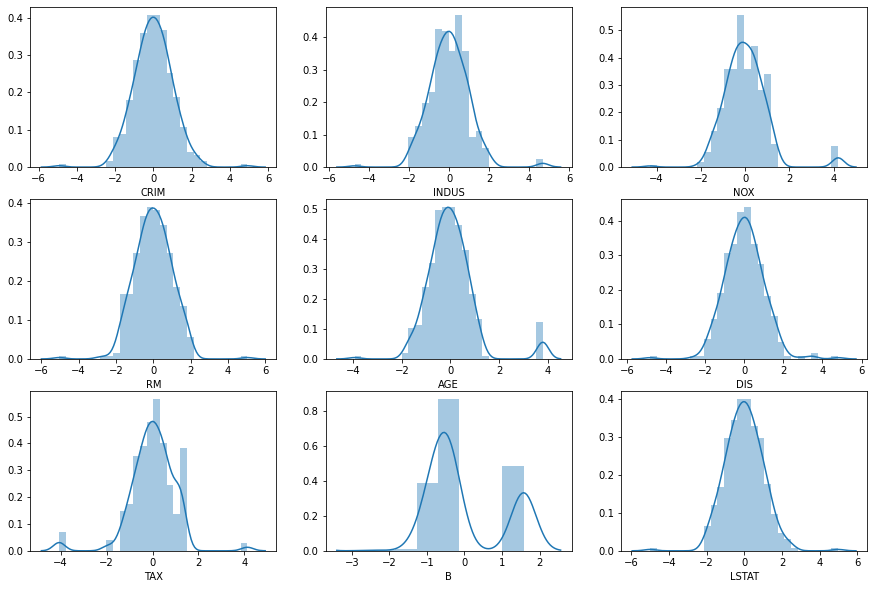

In [29]:
cols = 3
rows = int(len(X_train.columns)/cols)

plt.figure(figsize=(15,10))
for i,col in enumerate(X_train.columns):
    ax = plt.subplot(rows, cols, i+1)
    sns.distplot(X_train[col],ax=ax)

## cutting outliers again after normalization

In [30]:
X = X_train.copy()
X.loc[:,'MEDV']=y_train
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

X = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]
y_train = X['MEDV']
X_train = X.drop('MEDV',axis=1)

In [31]:
for k, v in X_train.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(X_train)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 0.33%
Column INDUS outliers = 0.00%
Column NOX outliers = 0.00%
Column RM outliers = 0.33%
Column AGE outliers = 0.00%
Column DIS outliers = 0.00%
Column TAX outliers = 0.00%
Column B outliers = 0.00%
Column LSTAT outliers = 0.33%


# Modeling

In [32]:
scores_map={}

# Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
scores = cross_val_score(LR_model,X_train,y_train,cv=10,n_jobs=-1,scoring='neg_mean_squared_error')
scores_map['LR']=scores
print('Logistic Regression negative RMSE {:.3f} (+/- {:.3f})'.format(scores.mean(),scores.std()))

Logistic Regression negative RMSE -0.015 (+/- 0.008)


# Support Vector Machine Regressor (SVR)

In [34]:
from sklearn.svm import SVR


svr_rbf = SVR(kernel='rbf')
grid = GridSearchCV(svr_rbf, cv=10, param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)}, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print("Best parameters :", grid.best_params_)
print("Best Score :{:.3f}".format(grid.best_score_))

Best parameters : {'C': 10.0, 'gamma': 0.01}
Best Score :-0.014


In [35]:
svr_rbf = SVR(kernel='rbf',C=10,gamma=0.01)

scores = cross_val_score(svr_rbf,X_train,y_train,cv=10,n_jobs=-1,scoring='neg_mean_squared_error')
scores_map['SVR']=scores
print('SVR negative RMSE {:.3f} (+/- {:.3f})'.format(scores.mean(),scores.std()))

SVR negative RMSE -0.014 (+/- 0.006)


# Decision Tree Regressor

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)
grid = GridSearchCV(tree, cv=10, param_grid={"max_depth" : [1, 2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print("Best parameters : ", grid.best_params_)
print("Best Score :{:.3f}".format(grid.best_score_))

Best parameters :  {'max_depth': 7}
Best Score :-0.020


In [37]:
tree = DecisionTreeRegressor(max_depth=7)
scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
scores_map['DTree'] = scores
print("D.Tree negative RMSE {:.3f} (+/- {:.3f})".format(scores.mean(),scores.std()))

D.Tree negative RMSE -0.022 (+/- 0.010)


# K Nearest Neighbours Regression (KNN)

In [38]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

grid = GridSearchCV(knn, cv=10, param_grid={"n_neighbors" : [2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print("Best parameters :", grid.best_params_)
print("Best Score :{:.3f}".format(grid.best_score_))

Best parameters : {'n_neighbors': 4}
Best Score :-0.019


In [39]:
knn = KNeighborsRegressor(n_neighbors=4)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
scores_map['KNN'] = scores
print("KNN negative RMSE {:.3f} (+/- {:.3f})".format(scores.mean(),scores.std()))

KNN negative RMSE -0.019 (+/- 0.007)


# Gradient Boosting

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=0)
param_grid={'n_estimators':[50,100,150, 200], 'learning_rate': [0.5,0.1,0.05,0.02,0.001]
            , 'max_depth':[2, 3,4,5,6,7,8], 'min_samples_leaf':[3,5,9,11,14,16]
            ,'min_samples_split':[2,4,6,8,10], 'alpha':[0.05,0.1,0.3,0.5]}
# grid = GridSearchCV(gbr, cv=10, param_grid=param_grid, scoring='neg_mean_squared_error')
grid = RandomizedSearchCV(gbr, cv=10, param_distributions=param_grid, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print("Best params :", grid.best_params_)
print("Best Score :{:.3f}".format(grid.best_score_))

Best params : {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 16, 'max_depth': 6, 'learning_rate': 0.02, 'alpha': 0.5}
Best Score :-0.015


In [41]:
gbr = GradientBoostingRegressor(n_estimators=200,min_samples_split=2,min_samples_leaf=3,max_depth=8,learning_rate=0.02,alpha=0.05,   random_state=0)
scores = cross_val_score(gbr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
scores_map['GBR'] = scores
print("GBR negative RMSE {:.3f} (+/- {:.3f})".format(scores.mean(),scores.std()))

GBR negative RMSE -0.015 (+/- 0.009)


# Performance Comparisions

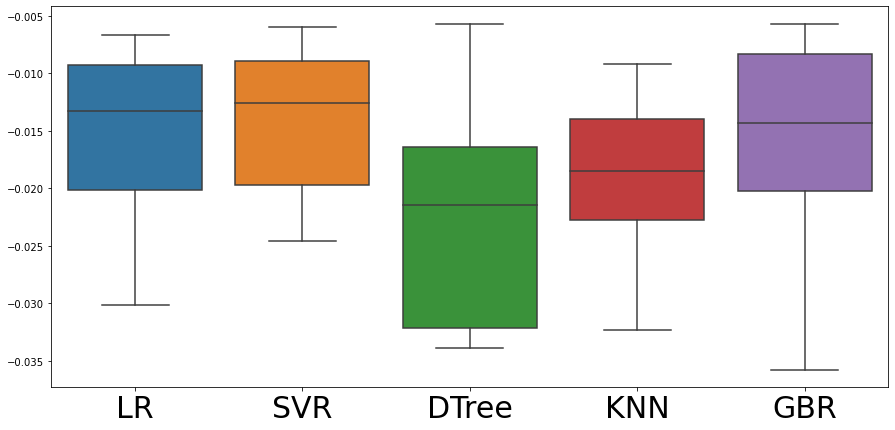

In [42]:
plt.figure(figsize=(15, 7))
scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=scores_map)
plt.xticks(fontsize=30)
plt.show()

**Analysis**
* almost all regressors are performing sholder to sholder

# Conclusion
This concludes your starter analysis! To go forward from here, click the blue "Edit Notebook" button at the top of the kernel. This will create a copy of the code and environment for you to edit. Delete, modify, and add code as you please. Happy Kaggling!